# Определение возраста покупателей

## Исследовательский анализ данных

In [4]:
# Импортируем необходимые библиотеки
import pandas as pd
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Выгружаем данные

Выгрузим CSV-файл `labels.csv` с двумя колонками: file_name и real_age, а также папку со всеми изображениями.

In [5]:
# Выгружаем датафрейм labels
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Выгружаем папку с изображениями
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(labels,'/datasets/faces/final_files',
                                           x_col='file_name', y_col='real_age',
                                           target_size=(224, 224), batch_size=32,
                                           class_mode='raw', seed=12345)

Found 7591 validated image filenames.


Мы выгрузили 7591 изображение из папки.

### Размер выборки

Посмотрим на размер датафрейма.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Наша выборка содержит **7591 строку и 2 столбца**. Типы данных корректны, пропуски отсутствуют.

Размер датафрейма соответствует количеству изображений в папке.

### График распределения возраста

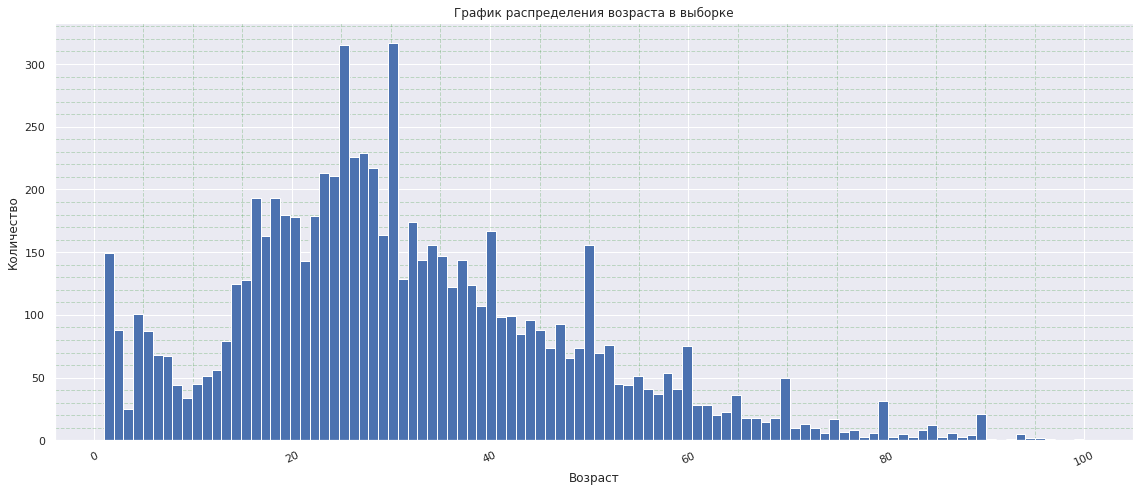

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
# Строим гистограмму
plt.figure(figsize=(16,7))
labels['real_age'].hist(bins=100)
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()
labels.describe()

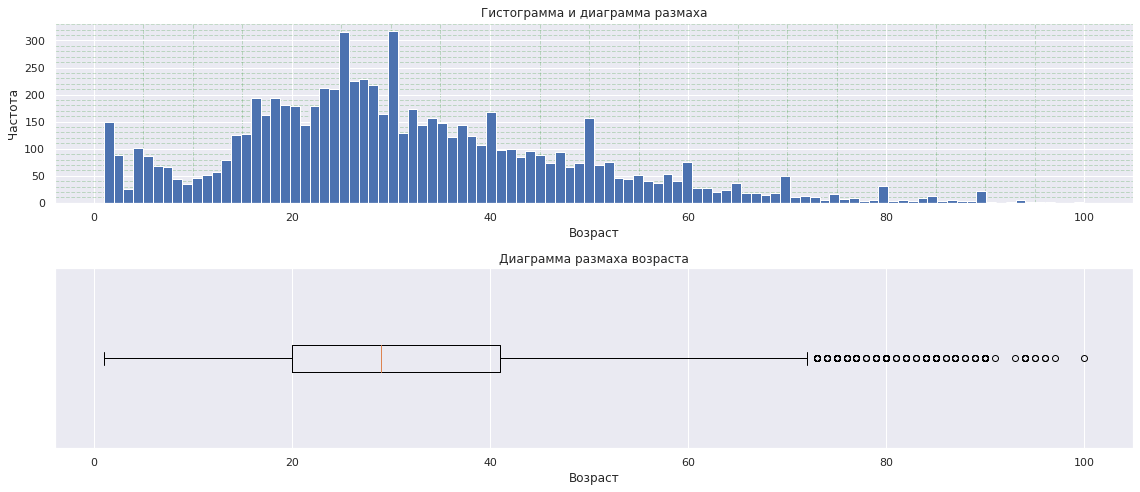

In [8]:
# Создание фигуры и подграфиков (2 строки, 1 столбец)
fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(16, 7))

# Гистограмма
ax_hist.hist(labels['real_age'], bins=100)
ax_hist.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
ax_hist.minorticks_on()
ax_hist.tick_params(which='minor')
ax_hist.set_xlabel('Возраст')
ax_hist.set_ylabel('Количество')
ax_hist.set_ylabel('Частота')
ax_hist.set_title('Гистограмма и диаграмма размаха')

# Диаграмма размаха (boxplot)
ax_box.boxplot(labels['real_age'], vert=False)
ax_box.set_title('Диаграмма размаха возраста')
ax_box.set_xlabel('Возраст')
ax_box.set_yticks([])  # Убираем метки по оси Y для boxplot

# Улучшение отступов
plt.tight_layout()
plt.show()

Мы видим, что минимальный возраст - 1 год, а максимальный 100 лет.
Наибольшее количество изображений находится в диапазоне от 20 до 40 лет.

Проверим соответсвие максимальному и минимальному возрасту и построим изображения.

In [6]:
print('Название изображения с возрастом 100 лет:', labels[labels['real_age']==100]['file_name'].iloc[0])
print('Название изображения с возрастом 1 год', labels[labels['real_age']==1]['file_name'].sample(random_state=42).iloc[0])

Название изображения с возрастом 100 лет: 002661.jpg
Название изображения с возрастом 1 год 003661.jpg


In [7]:
img_100 = Image.open('/datasets/faces/final_files/002661.jpg')
img_1 = Image.open('/datasets/faces/final_files/003661.jpg')

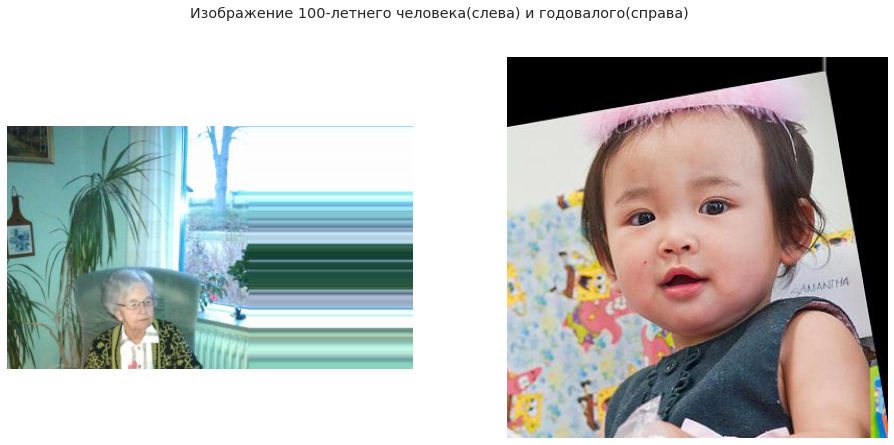

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 7))
fig.suptitle('Изображение 100-летнего человека(слева) и годовалого(справа)')
ax1.imshow(img_100)
ax1.axis('off')

ax2.imshow(img_1)
ax2.axis('off');

Изображения соответствуют действительности, диапазон возрастов лежит от 1 до 100.

### Как устроен датасет

Напечатаем на экране 15 фотографий и проанализируем.

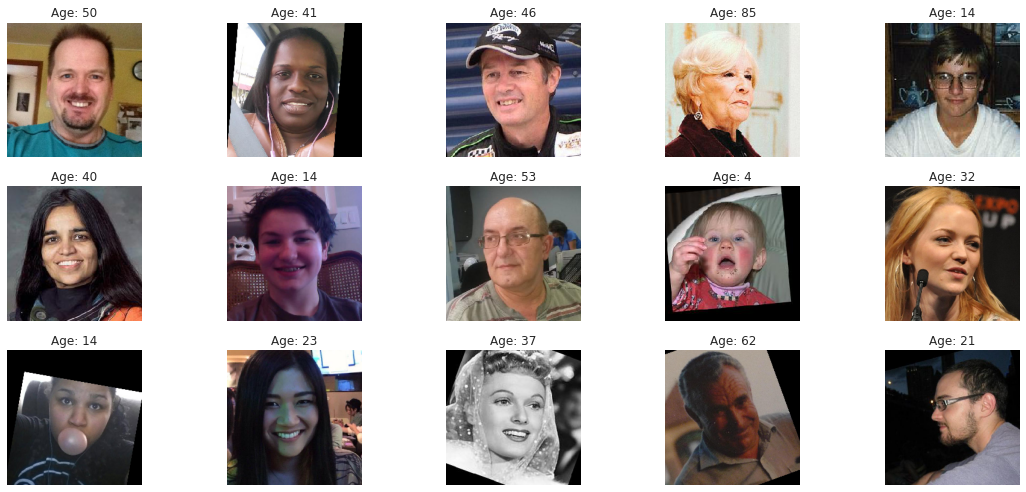

In [10]:
# Строим 15 изображений
img_batch, age_batch = next(datagen_flow)
plt.figure(figsize=(16, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(img_batch[i])
    plt.title(f'Age: {age_batch[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Мы видим,что есть изображения искаженные, повернутые, сжатые.  Возраст соответствует фото.

### Выводы

Мы будем имет дело с 7591 изображениях, на которых находятся люди возрастов от 1 до 100. Некоторые фото искаженные, повернутые, сжатые. 

Это может повлиять на обучение модели, так как в данных присутствует шум. Это может сделать ее более устойчивой к реальным данным и предотвратить переобучение.

## Обучение модели

Возьмем предобученную на ImageNet модель ResNet50. Нам нужен всего один нейрон с активацией ReLU, который вернёт число-предсказание. 

В качестве функции потерь мы взяли MSE, а скорость обучения уменьшили до 0.0001.

(Код в этом разделе запускается в отдельном GPU-сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import os



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,  
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=False)
    return model
```

Результат работы модели:

```
Train for 356 steps, validate for 119 steps

Epoch 1/5
356/356 - 53s - loss: 208.6990 - mae: 10.4346 - val_loss: 445.7191 - val_mae: 15.9553

Epoch 2/5
356/356 - 42s - loss: 83.6492 - mae: 6.9716 - val_loss: 222.2418 - val_mae: 11.2462

Epoch 3/5
356/356 - 42s - loss: 58.1353 - mae: 5.7902 - val_loss: 141.3378 - val_mae: 8.9010

Epoch 4/5
356/356 - 43s - loss: 44.5826 - mae: 5.1129 - val_loss: 125.5054 - val_mae: 8.3106

Epoch 5/5
356/356 - 43s - loss: 33.8843 - mae: 4.4479 - val_loss: 90.6608 - val_mae: 6.9434

119/119 - 10s - loss: 90.6608 - mae: 6.9434
```

## Анализ обученной модели

За 5 эпох у нас получилось добиться значения MAE на тестовой выборке = **6.9434**, что соответствует требованиям задачи.

Выборку мы разделили в соотношении 75:25, к тренировочным данным применили аугментацию в виде горизонтального отражения.

Для регресии использовали модель ResNet без верхнего классификатора и с одним выходным слоем.

Не было признаков катастрофического переобучения, разрыв между тренировочной метрикой и валидационной уменьшался. Модель уверенно обучалась: и на тренировочной, и на валидационной выборке метрика MAE снижалась.